# Initialize Dataset and Libraries

In [134]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as l

import time

In [135]:
# prompt: import mnist dataset and normalize the inputs

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

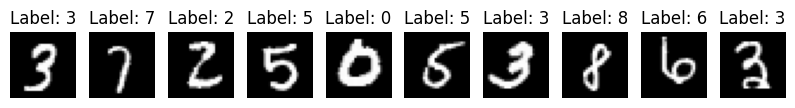

In [136]:
# prompt: show random sample of this dataset

import matplotlib.pyplot as plt
import numpy as np

# Choose a random sample of indices
num_samples = 10
random_indices = np.random.choice(x_train.shape[0], num_samples, replace=False)

# Plot the images and their labels
plt.figure(figsize=(10, 5))
for i, index in enumerate(random_indices):
  plt.subplot(1, num_samples, i + 1)
  plt.imshow(x_train[index], cmap='gray')
  plt.title(f"Label: {y_train[index]}")
  plt.axis('off')

plt.show()


# Inheriting from Conv2D for Pruning

In [137]:
# Conv2D ----------------------------------------------------------------
class PrunableConv2D(l.Conv2D):
    def __init__(self, *args, **kwargs):
        super(PrunableConv2D, self).__init__(*args, **kwargs)
        self.mask = None

    def build(self, input_shape):
        super(PrunableConv2D, self).build(input_shape)
        self.mask = tf.ones((1, 1, 1, self.filters))

    #@tf.function
    def call(self, inputs):
        return super(PrunableConv2D, self).call(inputs) * self.mask

    def mask_filter(self, filter_index=[]):
        # Mask
        mask = self.mask.numpy()
        for index in filter_index:
            mask[:, :, :, index] = 0
        self.mask = tf.cast(mask, self.dtype)

        # Weights
        weights = self.get_weights()
        for i in range(self.filters):
            if mask[:, :, :, i] == 0:
                weights[0][:, :, :, i] = 0
                if self.use_bias:
                    weights[1][i] = 0
        self.set_weights(weights)

    def reset_mask(self, filter_index=None):
        if filter_index is None:
          self.mask = tf.ones((1, 1, 1, self.filters))
        else:
            mask = self.mask.numpy()
            for index in filter_index:
                mask[:, :, :, index] = 1
            self.mask = tf.cast(mask, self.dtype)

    def get_config(self):
        config = super(PrunableConv2D, self).get_config()
        config.update({'mask': self.mask})
        return config

# Callback ---------------------------------------------------------------
class PruneConv2D_Callback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
          for layer in self.model.layers:
            if isinstance(layer, PrunableConv2D):
              mask = layer.mask.numpy()[0][0][0]
              weights = layer.get_weights()
              for i in range(layer.filters):
                if mask[i]==0:
                  weights[0][:,:,:,i] = 0
                  if layer.use_bias:
                    weights[1][i] = 0
              layer.set_weights(weights)

In [138]:
# Conv2D ----------------------------------------------------------------
class PrunableDense(l.Dense):
    def __init__(self, *args, **kwargs):
        super(PrunableDense, self).__init__(*args, **kwargs)
        self.mask = None

    def build(self, input_shape):
        super(PrunableDense, self).build(input_shape)
        self.mask = tf.ones((1, self.units))

    #@tf.function
    def call(self, inputs):
        return super(PrunableDense, self).call(inputs) * self.mask

    def mask_filter(self, unit_index=[]):
        # Mask
        mask = self.mask.numpy()
        for index in unit_index:
            mask[:, index] = 0
        self.mask = tf.cast(mask, self.dtype)

        # Weights
        weights = self.get_weights()
        for i in range(self.units):
            if mask[:, i] == 0:
                weights[0][:, i] = 0
                if self.use_bias:
                    weights[1][i] = 0
        self.set_weights(weights)

    def reset_mask(self, unit_index=None):
        if unit_index is None:
          self.mask = tf.ones((1, self.units))
        else:
            mask = self.mask.numpy()
            for index in unit_index:
                mask[:, index] = 1
            self.mask = tf.cast(mask, self.dtype)

    def get_config(self):
        config = super(PrunableDense, self).get_config()
        config.update({'mask': self.mask})
        return config

# Callback ---------------------------------------------------------------
class PruneDense_Callback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
          for layer in self.model.layers:
            if isinstance(layer, PrunableDense):
              mask = layer.mask.numpy()[0]
              weights = layer.get_weights()
              for i in range(layer.units):
                if mask[i]==0:
                  weights[0][:,i] = 0
                  if layer.use_bias:
                    weights[1][i] = 0
              layer.set_weights(weights)

# Define & Train Model

In [139]:
input = l.Input((28, 28, 1), name="Input_Layer")

x = l.ZeroPadding2D(padding=(2, 2), name="Zero_Padding_1")(input)
x = PrunableConv2D(filters=6, kernel_size=(5, 5), strides=1, padding='valid', activation='relu', name="PrunableConv2D_1")(x)
x = l.AveragePooling2D(pool_size=(2, 2), name="AveragePooling2D_1")(x)
x = PrunableConv2D(filters=16, kernel_size=(5, 5), strides=1, padding='valid', activation='relu', name="PrunableConv2D_2")(x)
x = l.AveragePooling2D(pool_size=(2, 2), name="AveragePooling2D_2")(x)
x = PrunableConv2D(filters=120, kernel_size=(5, 5), strides=1, padding='valid', activation='relu', name="PrunableConv2D_3")(x)

x = l.Flatten(name="Flatten_1")(x)
x = PrunableDense(units=84, activation='relu', name="Dense_1")(x)
output = l.Dense(units=10, activation='softmax', name="Dense_2")(x)

model = tf.keras.Model(inputs=input, outputs=output)
model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 Zero_Padding_1 (ZeroPadding  (None, 32, 32, 1)        0         
 2D)                                                             
                                                                 
 PrunableConv2D_1 (PrunableC  (None, 28, 28, 6)        156       
 onv2D)                                                          
                                                                 
 AveragePooling2D_1 (Average  (None, 14, 14, 6)        0         
 Pooling2D)                                                      
                                                                 
 PrunableConv2D_2 (PrunableC  (None, 10, 10, 16)       2416      
 onv2D)                                                   

In [140]:
model.compile(optimizer=tf.keras.optimizers.Nadam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [141]:
prune_callback = [PruneConv2D_Callback(), PruneDense_Callback()]
model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1, callbacks=prune_callback)

Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4330 - accuracy: 0.8652 - val_loss: 0.1261 - val_accuracy: 0.9650
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 0.1211 - accuracy: 0.9630 - val_loss: 0.0888 - val_accuracy: 0.9740
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 0.0793 - accuracy: 0.9761 - val_loss: 0.0665 - val_accuracy: 0.9810
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 0.0604 - accuracy: 0.9813 - val_loss: 0.0621 - val_accuracy: 0.9818
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 0.0513 - accuracy: 0.9846 - val_loss: 0.0479 - val_accuracy: 0.9873


# Evaluate Model

In [142]:
# Evaluate the model on the test set
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
print(f"Test Loss: {train_loss:.4f}")
print(f"Test Accuracy: {train_accuracy:.4f}")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0396
Test Accuracy: 0.9881
Test Loss: 0.0439
Test Accuracy: 0.9863


# Prune Model

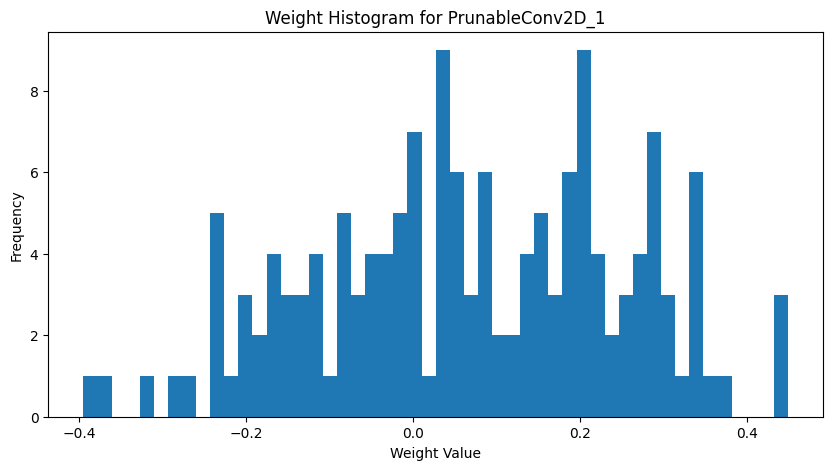

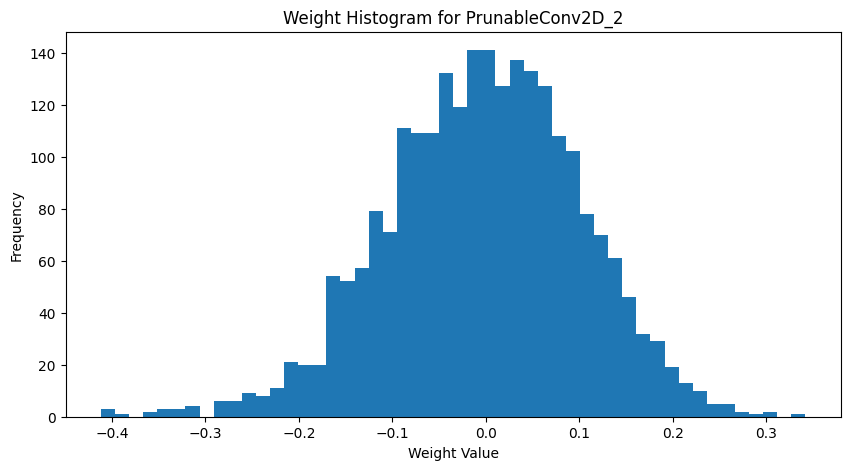

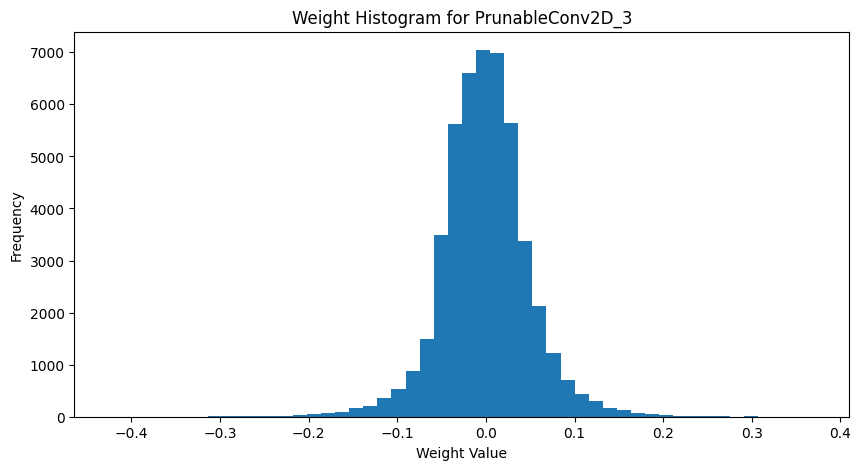

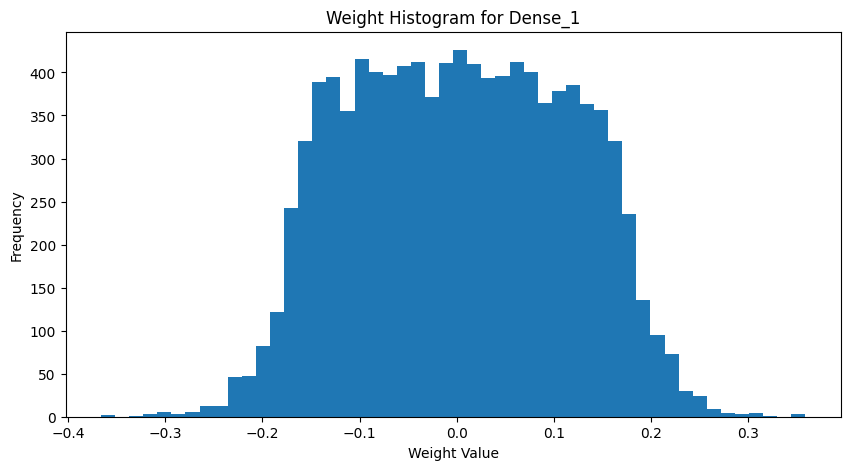

In [143]:
for layer in model.layers:
  if isinstance(layer, PrunableConv2D) or isinstance(layer, PrunableDense):
    weights = layer.get_weights()[0]
    plt.figure(figsize=(10, 5))
    plt.hist(weights.flatten(), bins=50)
    plt.title(f"Weight Histogram for {layer.name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.show()

In [144]:
prune_ratio = 0.5

for layer in model.layers:
  if isinstance(layer, PrunableConv2D):
    kernel = layer.get_weights()[0]
    avg_kernel = np.mean(np.abs(kernel), axis=(0, 1, 2))
    sorted_indices = np.argsort(avg_kernel)
    # find the index with the min value
    last_filter = int(layer.filters * prune_ratio)
    layer.mask_filter([sorted_indices[:last_filter]])
  elif isinstance(layer, PrunableDense):
    kernel = layer.get_weights()[0]
    avg_kernel = np.mean(np.abs(kernel), axis=0)
    sorted_indices = np.argsort(avg_kernel)
    # find the index with the min value
    last_unit = int(layer.units * prune_ratio)
    layer.mask_filter([sorted_indices[:last_unit]])

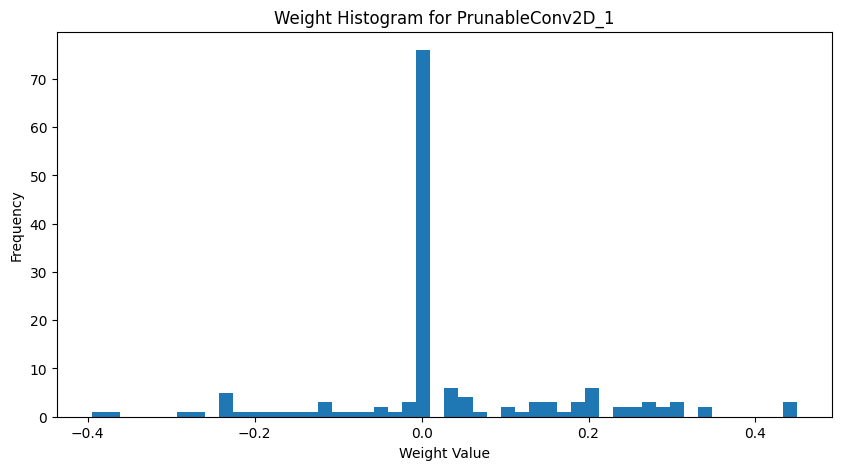

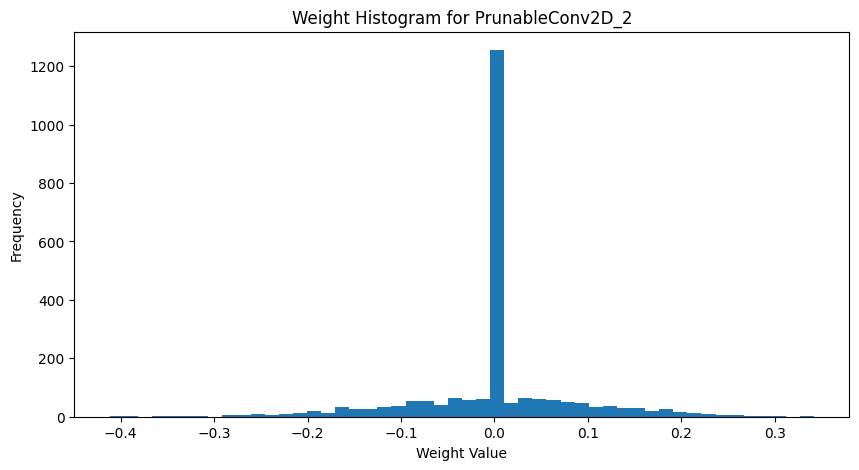

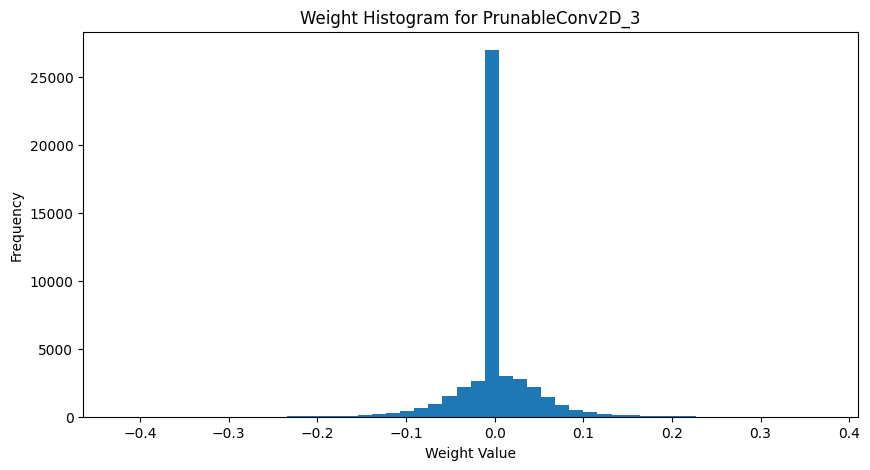

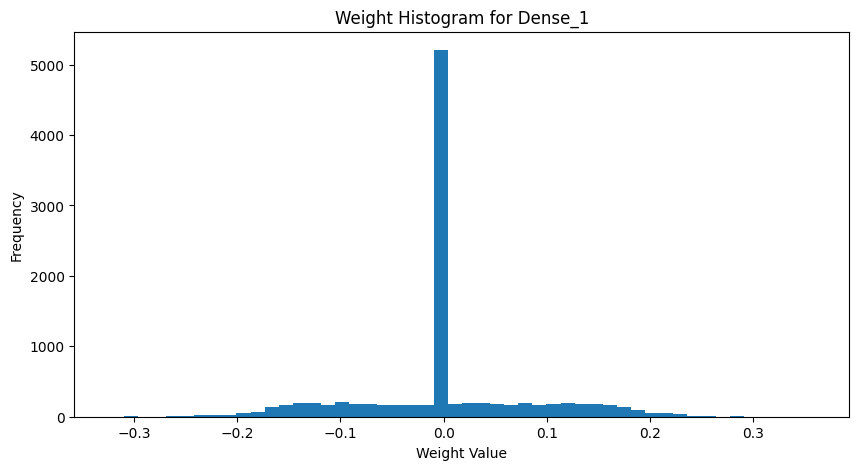

In [145]:
for layer in model.layers:
  if isinstance(layer, PrunableConv2D) or isinstance(layer, PrunableDense):
    weights = layer.get_weights()[0]
    plt.figure(figsize=(10, 5))
    plt.hist(weights.flatten(), bins=50)
    plt.title(f"Weight Histogram for {layer.name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.show()

In [146]:
# Evaluate the model on the train set
loss, accuracy = model.evaluate(x_train, y_train, verbose=0)
print(f"Train Loss: {loss:.4f}")
print(f"Train Accuracy: {accuracy:.4f}")

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")



Train Loss: 1.0923
Train Accuracy: 0.6223
Test Loss: 1.0766
Test Accuracy: 0.6252


In [147]:
model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1, callbacks=[prune_callback])

Epoch 1/5
422/422 [==============================] - 1s 3ms/step - loss: 0.0734 - accuracy: 0.9780 - val_loss: 0.0660 - val_accuracy: 0.9802
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 0.0526 - accuracy: 0.9838 - val_loss: 0.0520 - val_accuracy: 0.9848
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 0.0430 - accuracy: 0.9866 - val_loss: 0.0588 - val_accuracy: 0.9833
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 0.0381 - accuracy: 0.9880 - val_loss: 0.0512 - val_accuracy: 0.9860
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 0.0339 - accuracy: 0.9893 - val_loss: 0.0461 - val_accuracy: 0.9877


In [148]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=0)
print(f"Train Loss: {loss:.4f}")
print(f"Train Accuracy: {accuracy:.4f}")

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Train Loss: 0.0271
Train Accuracy: 0.9918
Test Loss: 0.0375
Test Accuracy: 0.9874


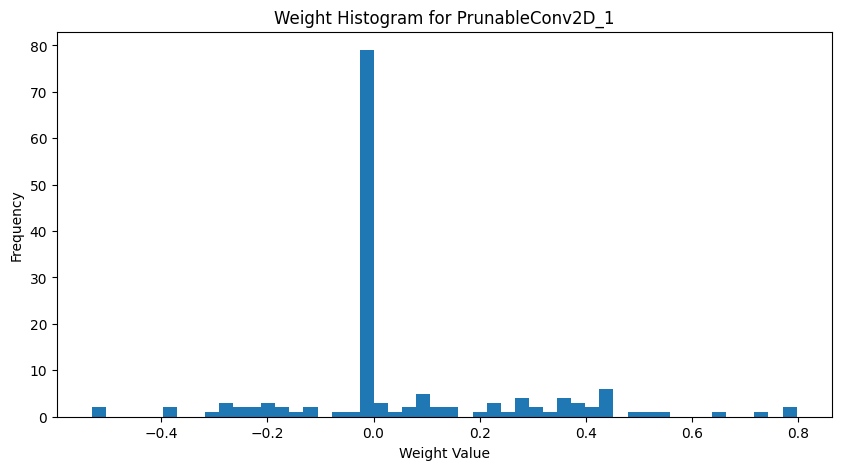

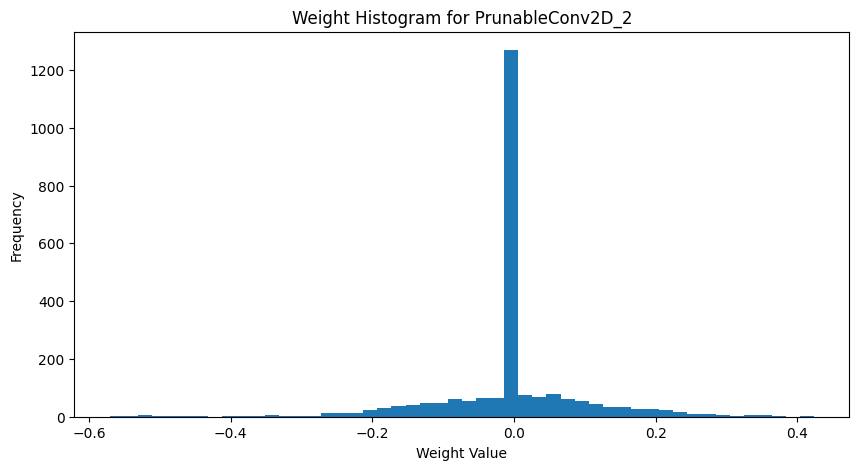

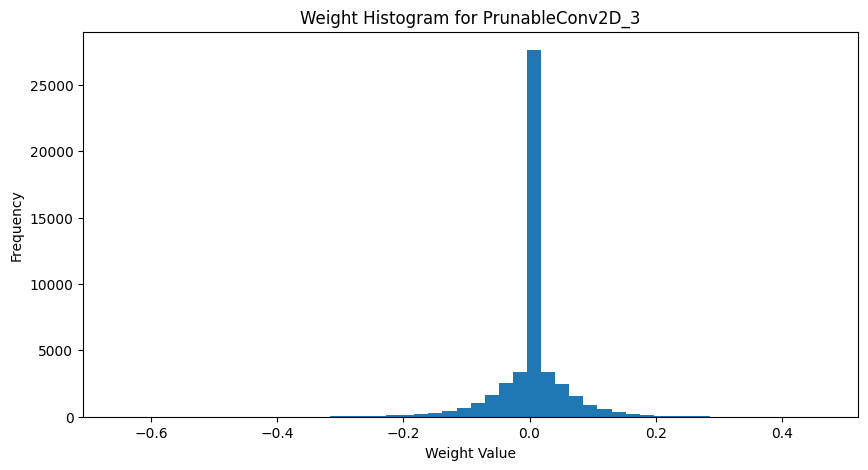

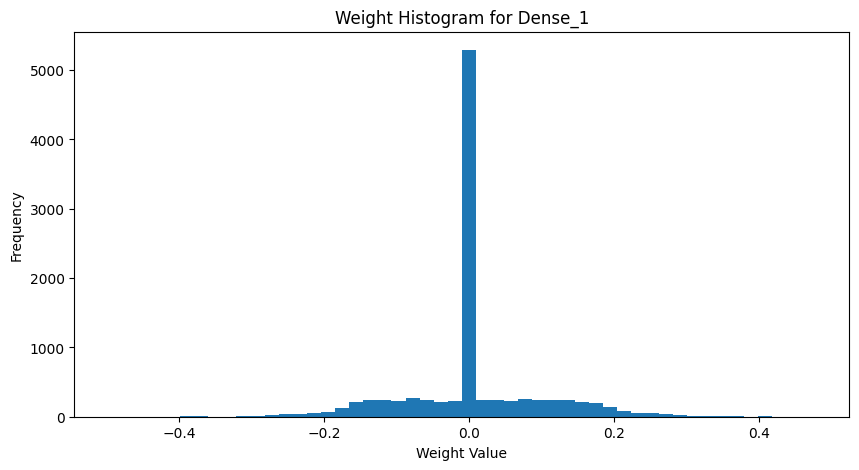

In [149]:
for layer in model.layers:
  if isinstance(layer, PrunableConv2D) or isinstance(layer, PrunableDense):
    weights = layer.get_weights()[0]
    plt.figure(figsize=(10, 5))
    plt.hist(weights.flatten(), bins=50)
    plt.title(f"Weight Histogram for {layer.name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.show()

# Slim Model

In [152]:
def slim_model(model):
  slim_model = tf.keras.models.Sequential();
  prev_active_filters_indices = None
  for layer in model.layers:
    if isinstance(layer, PrunableConv2D):
        # print(layer.name)

        active_filters = int(np.sum(layer.mask))
        # print(active_filters)

        conv_layer = l.Conv2D(filters=active_filters,
                              kernel_size=layer.kernel_size,
                              strides=layer.strides,
                              padding=layer.padding,
                              activation=layer.activation,
                              use_bias=layer.use_bias)
        

        kernels = layer.get_weights()[0]
        kernels_shape = kernels.shape
        if layer.use_bias:
          biases = layer.get_weights()[1]
          bias_shape = biases.shape

        # input channel
        input_channel = kernels_shape[2]
        if prev_active_filters_indices is not None:
          input_channel = len(prev_active_filters_indices)

        conv_layer.build((None, kernels_shape[0], kernels_shape[1], input_channel))
        # print(conv_layer.filters)
        # print(conv_layer.get_weights()[0].shape)

        kernel_template = np.zeros((kernels_shape[0], kernels_shape[1], input_channel, active_filters))
        if layer.use_bias:
          bias_template = np.zeros(active_filters,)

        active_indices = np.where(layer.mask == 1)[3]

        active_input_channel_indices = range(input_channel)
        if prev_active_filters_indices is not None:
          active_input_channel_indices = prev_active_filters_indices
          # print(active_input_channel_indices)
        
        i = 0
        for index in active_indices:
          j = 0
          for j_index in active_input_channel_indices:
            kernel_template[:, :, j, i] = kernels[:, :, j_index, index]
            j += 1

          if layer.use_bias:
            bias_template[i] = biases[index]
          i += 1


        active_weights = [kernel_template]
        if layer.use_bias:
          active_weights.append(bias_template)

        # print(active_weights[0].shape)
        conv_layer.set_weights(active_weights)
        slim_model.add(conv_layer)

        # adjust prev output channel with current input channel
        prev_active_filters_indices = active_indices

    elif isinstance(layer, PrunableDense):
        # print(layer.name)

        active_units = int(np.sum(layer.mask))
        # print(active_units)

        dense_layer = l.Dense(units=active_units,
                              activation=layer.activation,
                              use_bias=layer.use_bias)

        kernels = layer.get_weights()[0]
        kernels_shape = kernels.shape
        if layer.use_bias:
          biases = layer.get_weights()[1]
          bias_shape = biases.shape

        # input channel
        input_channel = kernels_shape[0]
        if prev_active_filters_indices is not None:
          input_channel = len(prev_active_filters_indices)

        dense_layer.build((None, input_channel))
        # print(dense_layer.units)
        # print(dense_layer.get_weights()[0].shape)

        kernel_template = np.zeros((input_channel, active_units))
        if layer.use_bias:
          bias_template = np.zeros(active_units,)

        active_indices = np.where(layer.mask == 1)[1]
        # print("active_indices: ", np.where(layer.mask == 1))
        # display(active_indices)

        active_input_channel_indices = range(input_channel)
        if prev_active_filters_indices is not None:
          active_input_channel_indices = prev_active_filters_indices
          # print(active_input_channel_indices)
        
        i = 0
        for index in active_indices:
          j = 0
          for j_index in active_input_channel_indices:
            kernel_template[j, i] = kernels[j_index, index]
            j += 1

          if layer.use_bias:
            bias_template[i] = biases[index]
          i += 1


        active_weights = [kernel_template]
        if layer.use_bias:
          active_weights.append(bias_template)

        # print(active_weights[0].shape)
        # print("Active Weights: ", active_weights[0])
        dense_layer.set_weights(active_weights)
        slim_model.add(dense_layer)

        # adjust prev output channel with current input channel
        prev_active_filters_indices = active_indices
    
    elif isinstance(layer, l.Dense):
        # print(layer.name)

        active_units = layer.units
        # print(active_units)

        dense_layer = l.Dense(units=active_units,
                              activation=layer.activation,
                              use_bias=layer.use_bias)

        kernels = layer.get_weights()[0]
        kernels_shape = kernels.shape
        if layer.use_bias:
          biases = layer.get_weights()[1]
          bias_shape = biases.shape

        # input channel
        input_channel = kernels_shape[0]
        if prev_active_filters_indices is not None:
          input_channel = len(prev_active_filters_indices)

        dense_layer.build((None, input_channel))
        # print(dense_layer.units)
        # print(dense_layer.get_weights()[0].shape)

        kernel_template = np.zeros((input_channel, active_units))
        if layer.use_bias:
          bias_template = np.zeros(active_units,)

        active_indices = [i for i in range(active_units)]

        active_input_channel_indices = range(input_channel)
        if prev_active_filters_indices is not None:
          active_input_channel_indices = prev_active_filters_indices
          # print(active_input_channel_indices)
        
        i = 0
        for index in active_indices:
          j = 0
          for j_index in active_input_channel_indices:
            kernel_template[j, i] = kernels[j_index, index]
            j += 1

          if layer.use_bias:
            bias_template[i] = biases[index]
          i += 1


        active_weights = [kernel_template]
        if layer.use_bias:
          active_weights.append(bias_template)

        # print(active_weights[0].shape)
        dense_layer.set_weights(active_weights)
        slim_model.add(dense_layer)
        
        # adjust prev output channel with current input channel
        prev_active_filters_indices = active_indices
    
    elif isinstance(layer, l.AveragePooling2D):
      # print(layer.name)
      new_layer = l.AveragePooling2D(pool_size=layer.pool_size)
      slim_model.add(new_layer)

    elif isinstance(layer, l.Flatten):
      # print(layer.name)
      new_layer = l.Flatten()
      slim_model.add(new_layer)

    elif isinstance(layer, l.ZeroPadding2D):
      # print(layer.name)
      new_layer = l.ZeroPadding2D(padding=layer.padding, input_shape=layer.input_shape)
      slim_model.add(new_layer)

    # elif isinstance(layer, l.Input):
    #   print(layer.name)
      
    else:
      print(layer.name)
      slim_model.add(layer)

  return slim_model

In [153]:
slim_model = slim_model(model)

slim_model.compile(optimizer=tf.keras.optimizers.Nadam(),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

slim_model.summary()

Input_Layer
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_9 (ZeroPaddi  (None, 32, 32, 1)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 3)         78        
                                                                 
 average_pooling2d_26 (Avera  (None, 14, 14, 3)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_40 (Conv2D)          (None, 10, 10, 8)         608       
                                                                 
 average_pooling2d_27 (Avera  (None, 5, 5, 8)          0         
 gePooling2D)                                                    
                                         

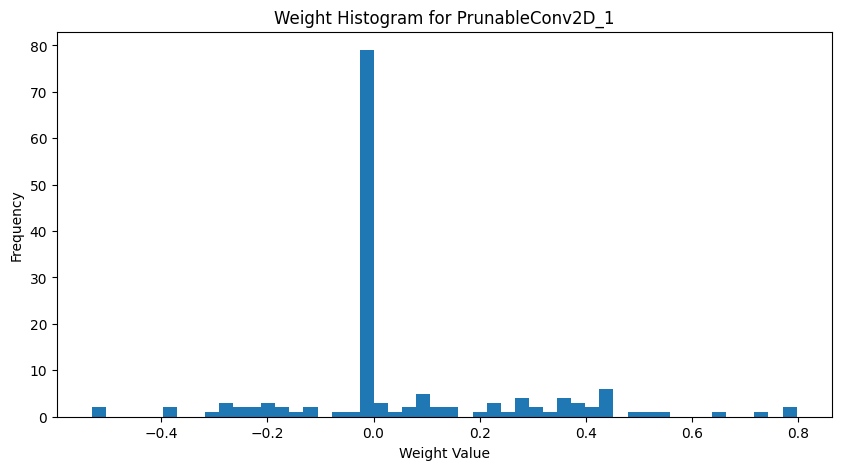

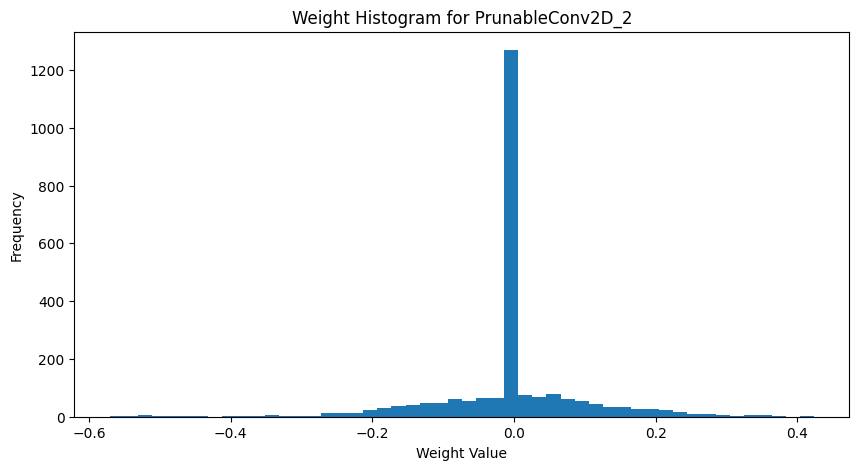

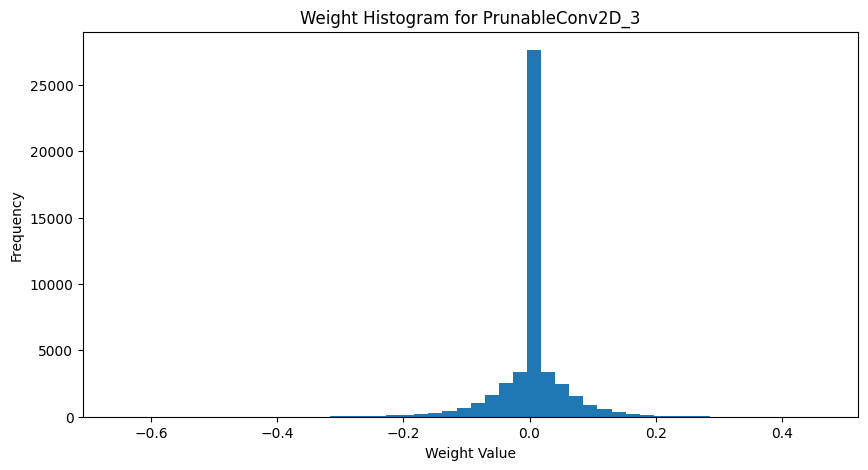

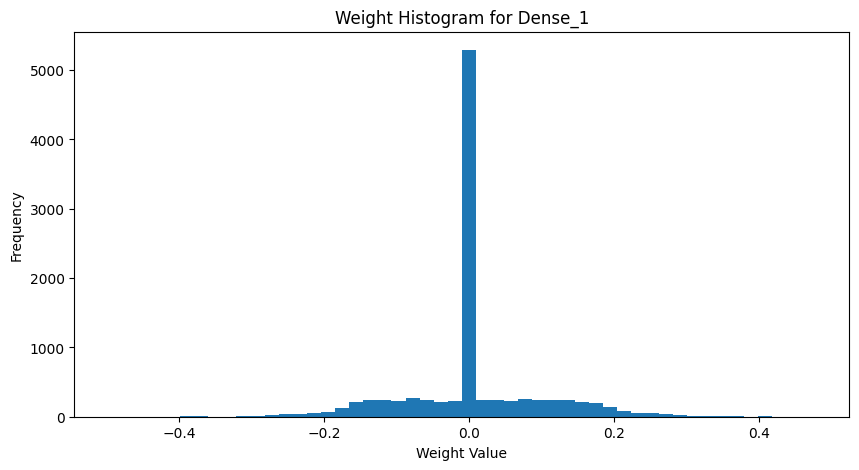

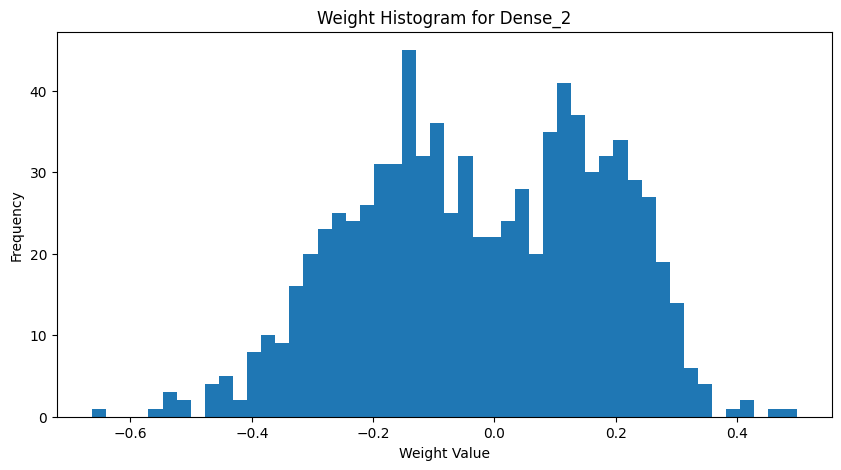

In [154]:
for layer in model.layers:
  if isinstance(layer, l.Conv2D) or isinstance(layer, l.Dense):
    weights = layer.get_weights()[0]
    plt.figure(figsize=(10, 5))
    plt.hist(weights.flatten(), bins=50)
    plt.title(f"Weight Histogram for {layer.name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.show()

In [155]:
loss, accuracy = slim_model.evaluate(x_train, y_train, verbose=0)
print(f"Train Loss: {loss:.4f}")
print(f"Train Accuracy: {accuracy:.4f}")

loss, accuracy = slim_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Train Loss: 0.0271
Train Accuracy: 0.9919
Test Loss: 0.0375
Test Accuracy: 0.9874


# THE END